# Introdução

## Dissecting GitHub Code Reviews: A Text Classification Experiment


Esse script é baseado no trabalho de Muntazir Fadhel, disponível em:

http://mfadhel.com/github-code-reviews/

# Objetivos 

Reproduzir o experimento de Fadhel, utilizando como entrada comentários de Pull Requests do projeto [Flutter](https://github.com/flutter/flutter).

# To-Do

> (X) Fazer o download dos dados do projeto Flutter;

> (X) Classificar manualmente os comentários de PR;

> (X) Reproduzir o experimento;

> (X) Começar a estudar os algoritmos de classificação;

> (X) Atualizar o arquivo Meeting Minutes.

## Input dos dados

Estão disponíveis em [input](./input/)

* Foram coletados comentários de revisão de 2586 Pull Requests do projeto Flutter;
* Destes, apenas 1792 pussuíam pelo menos 1 comentário;
* No total foram coletados **6261** comentários.


<p>&nbsp;</p>

A estrutura dos arquivos de input é:

[flutter_review_comments.txt](./input/flutter_review_comments.txt): arquivo contendo todos os comentários mencionados.

[flutter_development_set_review_comments.txt](./input/flutter_development_set_review_comments.txt): arquivo contendo um subconjunto de **200** comentários randomicamente selecionados, que serão utilizados neste experimento.

[flutter_development_set_review_comments_labels.txt](./input/flutter_development_set_review_comments_labels.txt): arquivo contendo os labels associados ao subconjunto mencionado.

<p>&nbsp;</p>

As categorias definidas por Fadhel são as seguintes:

| Category| Label | Further Explanation|  &nbsp; &nbsp; &nbsp;Sample Comment &nbsp; &nbsp; &nbsp;    |    
|-------------------|-------|--------------|-------------------------------------------------------|
| Readability                     | 1     | Comments related to readability, style, general project conventions.                                | "Please split this statement into two separate ones" |
| Naming                          | 2     |                                                                                                     | "I think foo would be a more appropriate name" |
| Documentation                   | 3     | Comments related to licenses, package info, module documentation, commenting.                       |"Please add a comment here explaining this logic" |
| Error/Resource Handling         | 4     | Comments related to exception/resource handling, program failure,  termination analysis, resource . |"Forgot to catch a possible exception here" |
| Control Structures/Program Flow | 5     | Comments related to usage of loops, if-statements, placement of individual lines of code.           |"This if-statement should be moved after the while loop" |
| Visibility/ Access              | 6     | Comments related to access level for classes, fields, methods and local variables.                  |"Make this final" |
| Efficiency / Optimization       | 7     |                                                                                                     |"Many uneccessary calls to foo() here" |
| Code Organization/ Refactoring  | 8     | Comments related to extracting code from methods and classes, moving large chunks of code around.   |"Please extract this logic into a separate method" |
| Concurrency                     | 9    | Comments related to threads, synchronization, parallelism.                                          |"This class does not look thread safe" |
| High Level Method Semantics & Design                           | 10    | Comments relating to method design and semantics.                                                           |"This method should return a String" |
| High Level Class Semantics & Design                           | 11    | Comments relating to class design and semantics.                                                           |"This should extend Foo" |
| Testing                           | 12    |                                                           |"is there a test for this?" |
| Other                           | 13    | Comments not relating to categories 1-12.                                                           |"Looks good", "done", "thanks" |

In [1]:
with open('input/flutter_development_set_review_comments.txt') as f:
    review_comments = f.readlines()
    
with open('input/flutter_development_set_review_comments_labels.txt') as g:
    classifications = g.readlines()

## Pré-processamento dos dados

O trecho de código a seguir é uma implementação sugerida por Fadhel de pré-processamento dos dados. Segundo ele, a remoção de stopwords e "stemmizadores" resultam numa queda da acurácia do classificador final.

In [2]:
import re 

def formatComment(comment):
        comment = re.sub("\*|\[|\]|#|\!|,|\.|\"|;|\?|\(|\)|`.*?`", "", comment)
        comment = re.sub("\.|\(|\)|<|>", " ", comment)
        comment = ' '.join(comment.split())
        return comment
        

def formatComments(comments):
    for index, comment in enumerate(comments):
        comments[index] = formatComment(comment)  

formatComments(review_comments)

## Extração de Features
* Ele utiliza o modelo _bag of words_ e faz a vetorização das palavras dos comentários

In [3]:
# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='word')
comments_train_counts = count_vect.fit_transform(review_comments)
comments_train_counts.shape

(200, 1029)

* Após a vetorização dos comentários de revisão, o autor utiliza TF-IDF para atribuir um peso à cada palavra presente no conjunto.

In [4]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
comments_train_tfidf = tfidf_transformer.fit_transform(comments_train_counts)
comments_train_tfidf.shape

(200, 1029)

## Divisão dos dados em treino/teste

In [19]:
from sklearn.model_selection import train_test_split

comment_train, comment_test, classification_train, classification_test = train_test_split(review_comments, classifications, test_size=0.15)

## Treino de um SVM
O autor utiliza Stochastic Gradient Descent (SGD) para realizar o treinamento de um SVM.

In [20]:
# Training Support Vector Machines - SVM and calculating its performance
from sklearn.metrics import classification_report
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), 
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='elasticnet',alpha=1e-3, max_iter=1000, random_state=42))])

text_clf_svm = text_clf_svm.fit(review_comments, classifications)
predicted_svm = text_clf_svm.predict(comment_test)
print(classification_report(classification_test, predicted_svm))

              precision    recall  f1-score   support

          1
       1.00      1.00      1.00         2
         11
       1.00      1.00      1.00         1
         12
       1.00      1.00      1.00         1
         13
       0.75      1.00      0.86         6
          2
       1.00      1.00      1.00         1
          3
       1.00      1.00      1.00         2
          4
       1.00      1.00      1.00         5
          5
       1.00      0.50      0.67         2
          7
       1.00      1.00      1.00         4
          8
       1.00      0.75      0.86         4
          9
       1.00      1.00      1.00         2

    accuracy                           0.93        30
   macro avg       0.98      0.93      0.94        30
weighted avg       0.95      0.93      0.93        30



## Problema!

In [21]:
# Training Support Vector Machines - SVM and calculating its performance
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()), 
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='elasticnet',alpha=1e-3, max_iter=1000, random_state=42))])

text_clf_svm = text_clf_svm.fit(review_comments, classifications)
predicted_svm = text_clf_svm.predict(comment_test)
print(classification_report(classification_test, predicted_svm))

              precision    recall  f1-score   support

          1
       1.00      1.00      1.00         2
         11
       1.00      1.00      1.00         1
         12
       1.00      1.00      1.00         1
         13
       1.00      1.00      1.00         6
          2
       1.00      1.00      1.00         1
          3
       1.00      1.00      1.00         2
          4
       1.00      1.00      1.00         5
          5
       0.67      1.00      0.80         2
          7
       1.00      1.00      1.00         4
          8
       1.00      0.75      0.86         4
          9
       1.00      1.00      1.00         2

    accuracy                           0.97        30
   macro avg       0.97      0.98      0.97        30
weighted avg       0.98      0.97      0.97        30



## Plot
Aqui cada um dos comentários de revisão é classificado utilizando o SVM treinado. E essa classificação é plotada num `donut chart`

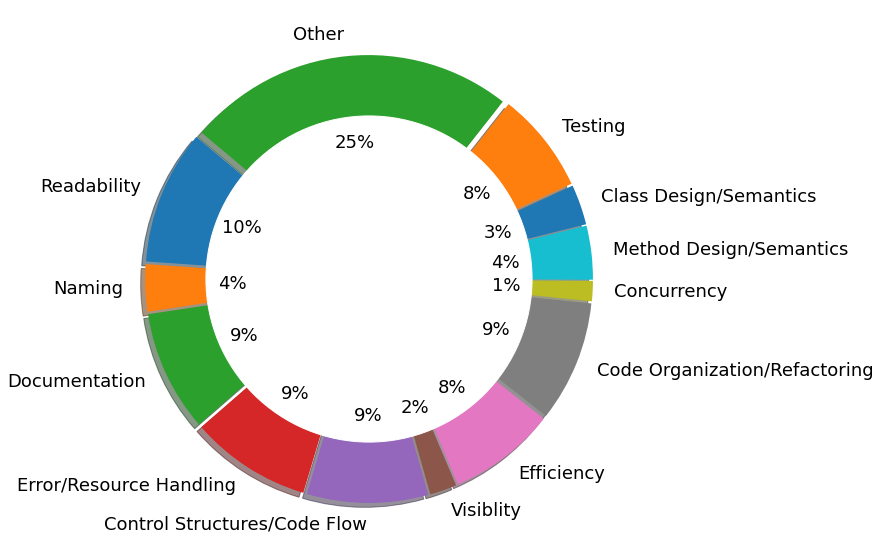

In [23]:
import matplotlib.pyplot as plt
import matplotlib
from palettable.tableau import Tableau_10

matplotlib.rcParams.update({'font.size': 18})

# Data to plot
labels = ['Readability', 'Naming', 'Documentation', 'Error/Resource Handling', 
'Control Structures/Code Flow', 'Visiblity', 'Efficiency', 'Code Organization/Refactoring',
'Concurrency', 'Method Design/Semantics', 'Class Design/Semantics', 'Testing', 'Other']


sizes = [0] * 13
explode = [0.03] * 13

# loop through review comments and score
for review_comment in review_comments:
    label = int(text_clf_svm.predict([formatComment(review_comment)])[0])
    sizes[label - 1] += 1

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.75, color='white')

# Plot
plt.pie(sizes, labels=labels, colors=Tableau_10.hex_colors,
        autopct='%1.0f%%', explode=explode, shadow=True, startangle=140) 
fig = plt.gcf().set_size_inches(10,10) 
plt.gca().add_artist(my_circle)
plt.show()